In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 862.4 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import cv2
import warnings
warnings.simplefilter("ignore")
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
model = YOLO('yolov8n-pose.pt')

In [5]:
def significant_pose_detection(arr, th):
    n = len(arr)
    i = 0
    for itemm in arr:
        if np.sum(itemm[0] + itemm[1]) != 0:
            i = i + 1

    sig_det = (i / n)
    if sig_det >= th:
        return 1

    return 0

def process_image(input_image_path, output_image_path):
    # Open the image file
    image = cv2.imread(input_image_path)

    # Process the image here...
    results = model.predict(image)[0]
    th = 0.3
    Q = []
    det = 0
    concat_df = pd.DataFrame()

    for result in results:
        landmarks = []
        kpts = result.keypoints
        nk = kpts.shape[1]

        for i in range(nk):
            keypoint = kpts.xy[0, i]
            x, y = int(keypoint[0].item()), int(keypoint[1].item())
            landmarks.append([x, y])

        detections = significant_pose_detection(landmarks, th)
        if detections == 1:
            det = det + 1
            for j in range(len(landmarks)):
                x = landmarks[j][0]
                y = landmarks[j][1]
                # cv2.circle(image, (x, y), 3, (0, 0, 255), -1)
                ttext = "("+str(x)+","+str(y)+")"
                # cv2.putText(image, ttext, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

            df = pd.DataFrame(landmarks, columns=['x' + str(det), 'y' + str(det)], dtype=float)
            concat_df = pd.concat([concat_df, df], axis=1)

            # cv2.line(image, landmarks[11], landmarks[12], (0, 255, 0), 2)
            a = (landmarks[11][0] + landmarks[12][0]) // 2
            b = (landmarks[11][1] + landmarks[12][1]) // 2
            Q.append([a, b])

    m = list(map(lambda l: [v for v in l if v != 0], Q))
    nQ = [ele for ele in m if ele != []]

    k = len(nQ)

    i = 0
    while i < (k - 1):
        # cv2.line(image, nQ[i], nQ[i + 1], (255, 0, 0), 2)
        i = i + 1

    i = 0
    while i < k:
        # cv2.circle(image, nQ[i], 5, (0, 255, 255), -1)
        # cv2.circle(image, nQ[i], 7, (0, 0, 255), 2)
        i = i + 1

    concat_df.to_csv('detected_pose.csv')
    df_nQ = pd.DataFrame(nQ, columns=['x', 'y'], dtype=int)
    df_nQ.to_csv('nQ_centroids.csv')

    # Perform polynomial regression and outlier detection
    url = 'nQ_centroids.csv'
    data = pd.read_csv(url)
    x = data['x'].values
    y = data['y'].values

    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)  # Adjust the degree as necessary
    x_poly = poly.fit_transform(x.reshape(-1, 1))

    poly_reg = LinearRegression()
    poly_reg.fit(x_poly, y)

    y_pred_poly = poly_reg.predict(x_poly)
    residuals_poly = y - y_pred_poly

    # Residual analysis
    residuals_std_poly = np.std(residuals_poly)

    ci_lower_poly = y_pred_poly - 1.440 * residuals_std_poly
    ci_upper_poly = y_pred_poly + 1.440 * residuals_std_poly

    outliers_poly = np.where((y < ci_lower_poly) | (y > ci_upper_poly))

    print("Outliers (Polynomial): ", outliers_poly)

    # Draw rectangles around outliers
    for i in outliers_poly[0]:
        x_coords = concat_df['x' + str(i + 1)].dropna().values
        y_coords = concat_df['y' + str(i + 1)].dropna().values
        person = np.column_stack((x_coords, y_coords))
        person = person[~np.all(person == [0, 0], axis=1)]
        x_min, y_min = np.min(person, axis=0)
        x_max, y_max = np.max(person, axis=0)
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 0, 255), 2)

    # Save the processed image to the output path
    cv2.imwrite(output_image_path, image)
    cv2_imshow(image)


0: 448x640 12 persons, 354.8ms
Speed: 17.2ms preprocess, 354.8ms inference, 30.5ms postprocess per image at shape (1, 3, 448, 640)
Outliers (Polynomial):  (array([0, 7]),)


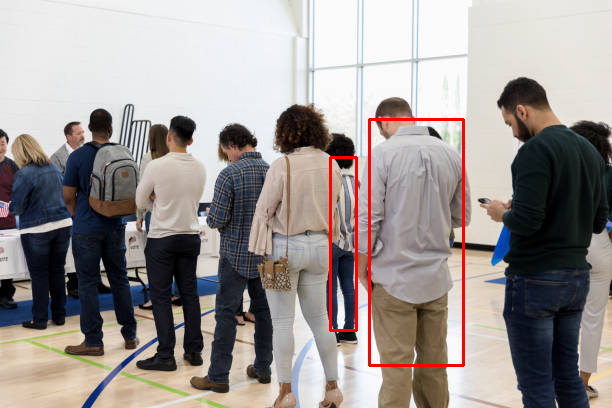

In [6]:
process_image('Q3_pose.png','Output.png')


0: 448x640 8 persons, 188.7ms
Speed: 3.8ms preprocess, 188.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Outliers (Polynomial):  (array([4]),)


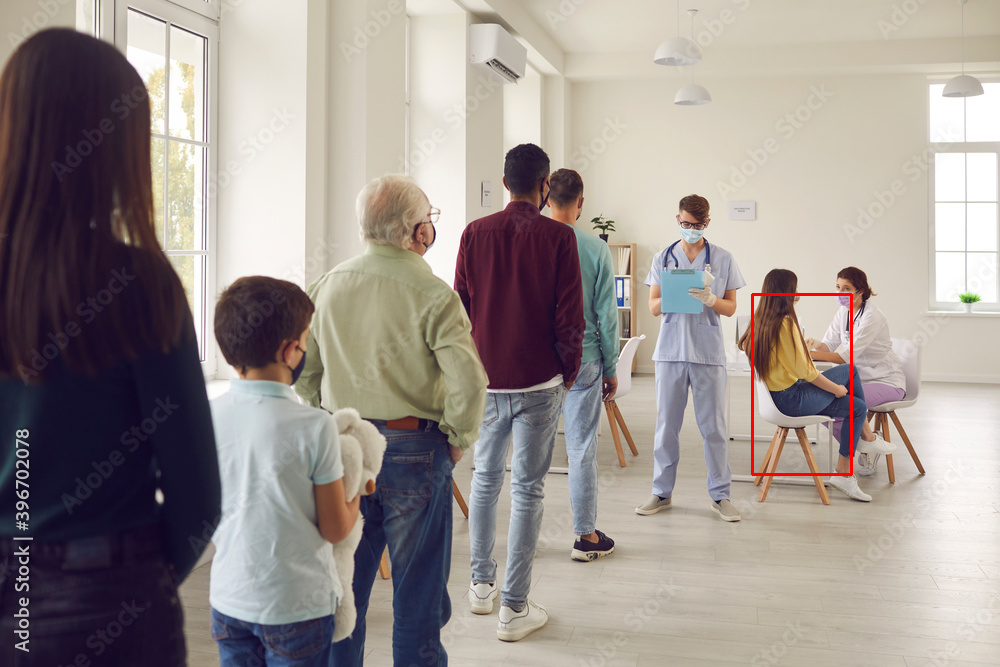

In [7]:
process_image('Q3_pose5.jpg','Output.png')

In [8]:
process_image('Q3_pose6.jpg','Output.png')


0: 544x640 8 persons, 271.2ms
Speed: 7.2ms preprocess, 271.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
Outliers (Polynomial):  (array([2]),)



0: 480x640 10 persons, 204.3ms
Speed: 5.6ms preprocess, 204.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Outliers (Polynomial):  (array([2, 7]),)


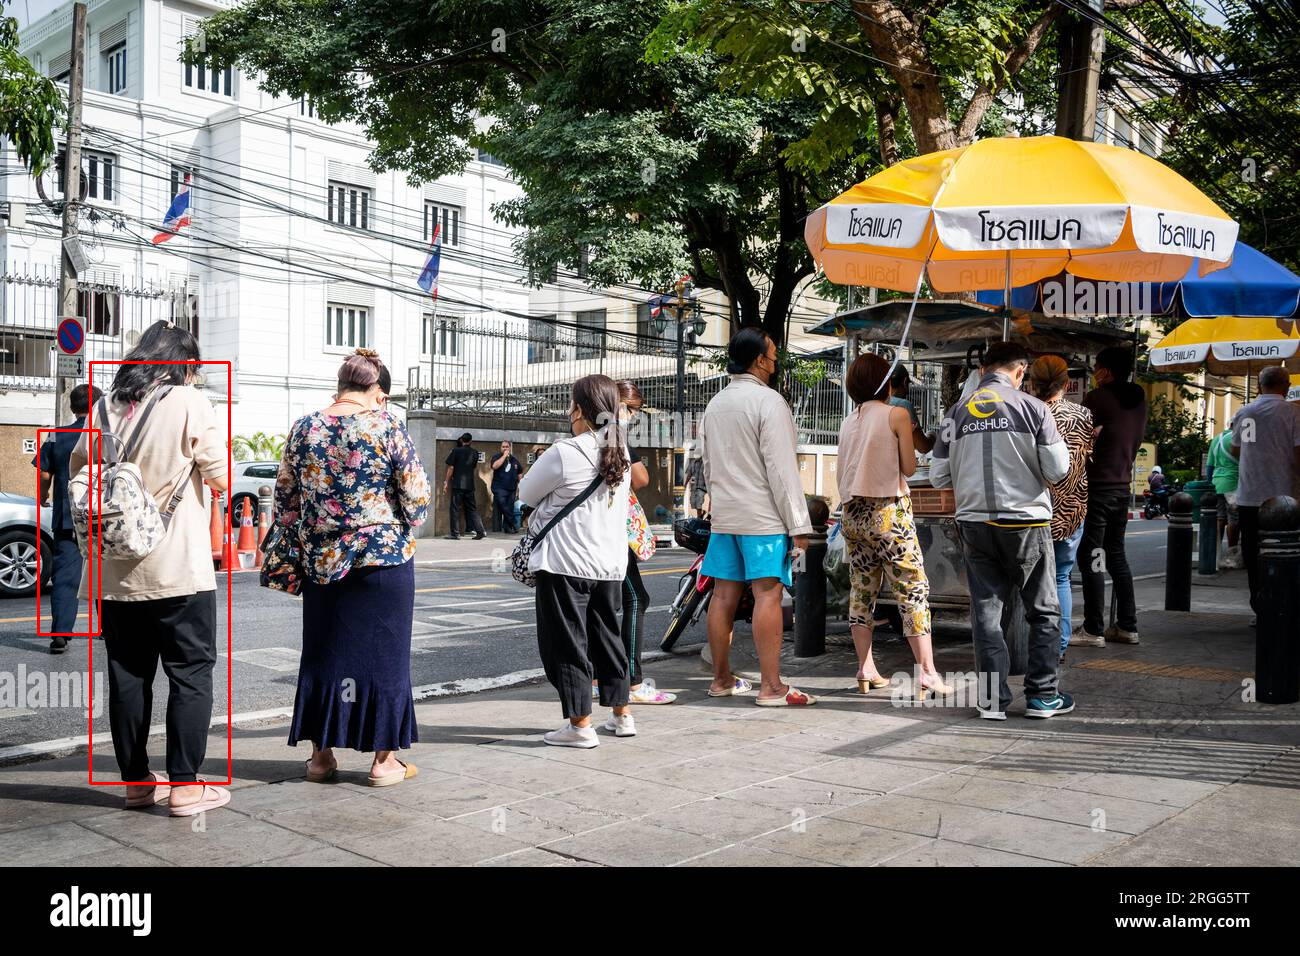

In [9]:
process_image('Q3_pose8.jpg','Output.png')